## Attention linking PoC: Part I

This is an overview of the research of utilizing attention in aim for more accurate and transparent Information Retrieval.

### Hyphotesis:

Transformers' attention reflects the internal relations of entities in the text and hence does reflect the importance of the pieces of text.

### Experiment Methodology:

We aggregate the selected attention heads' weights $W$ of all keys (=input wordpiece) for all values (=output wordpieces). We observe, whether, and how much the aggregated weights for "keyphrases" outweight the other parts of text.

We experiments with various methods of attention heads' aggregation:

1. aggregate all heads in given layer. It was shown that lower-level layers really reflect the morphology and higher reflect semantical properties, so coreferencing is a good candidate for higher-level layers.

2. aggregate multiple layers after aggregation 1. 

3. do not aggregate and use the head in standalone

Additionally, we might want to try nonlinear token classification of keywords, based on each layer. This can be then done also on the Transformer output.

## This notebook

Here, we explore the approach 3) and observe, whether the attentions of particular heads are significantly higher for keyphrase parts of the texts, as compared to the others.

### Evaluation

We measure the contrast of weights to keyphrases, compared to other pieces of text. We quantify the contrast by the mean value per-wordpiece and by distribution, visually, and by descriptive statistics.

### Output:

We pick the methodology, that gives the highest aggregated contrast of weights to keyphrases, compared to other pieces of text. This will be used in Information Retrieval system to weight the SCU present in the text.

### Attention inference with pretrained models + visualization

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!pip install transformers

In [2]:
from bertviz import neuron_view
from transformers import BertTokenizer, BertModel

In [3]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [4]:
from bertviz import head_view
from transformers import GPT2Tokenizer, GPT2Model

In [8]:
# version: BERT
# Note: works only in running jupyter notebook, in browser
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

sentence_a = "This morning, the president announced it."
# sentence_b = "The cat lay on the rug"
sentence_b = sentence_a

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
head_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# version: GPT-2
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version)

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
# NOTE: this updates the visualization above
head_view(attention, tokens)

### Keyphrases load

In [10]:
from common import *
ktexts = get_keyphrased_texts()
len(ktexts)

500

In [11]:
next(iter(ktexts.items()))

('crime-20955954',
 {'keywords': ['appear',
   'Sedgley',
   'pushing',
   'face near',
   'upper body',
   'serious wounds',
   'charged',
   'wounding another pupil Witnesses',
   'floor',
   'due',
   'car',
   'drove',
   'accused',
   'released',
   'attempted murder',
   'girl',
   'treated',
   'magistrates',
   'man',
   'Friday',
   'leapt',
   'stabbing',
   'gates',
   'school',
   'stabbed outside',
   'hospital earlier',
   'body',
   'Chloe',
   'stabbed',
   'leapt out',
   'Man charged',
   'Chloe West',
   'before pushing',
   'murder',
   'stabbing her',
   'face',
   'man drove up',
   'Saturday Samuel Tomlinson',
   'Dudley magistrates',
   '14yearold girl',
   '0840 BST'],
  'text': "Man charged with attempted murder of Chloe West\nA man has been charged with the attempted murder of a 14-year-old girl who was stabbed outside her school. Chloe West suffered serious wounds to her upper body and face near the gates of Ridgewood High School in Wollaston in the West Mid

### Ratio of relative attentions collection

Relative attention = (mean attention value of key wordpieces) - (of the other wordpieces)  

In [12]:
import pandas as pd
links_m_df = collect_links(ktexts)
links_m_df = links_m_df[links_m_df.attention != -1]

links_m_df

bert: 500it [57:14,  6.87s/it]
gpt: 3it [00:22,  7.52s/it]

No keywords in max_length window


gpt: 8it [01:10,  8.61s/it]

No keywords in max_length window


gpt: 16it [02:20,  9.14s/it]

No keywords in max_length window


gpt: 24it [03:19,  7.38s/it]

No keywords in max_length window


gpt: 32it [04:33,  9.14s/it]

No keywords in max_length window


gpt: 41it [06:23, 11.66s/it]

No keywords in max_length window


gpt: 45it [07:02,  9.96s/it]

No keywords in max_length window


gpt: 48it [07:23,  8.02s/it]

No keywords in max_length window


gpt: 60it [08:57,  7.15s/it]

No keywords in max_length window


gpt: 63it [09:20,  7.53s/it]

No keywords in max_length window


gpt: 66it [09:46,  8.36s/it]

No keywords in max_length window


gpt: 74it [10:53,  8.44s/it]

No keywords in max_length window


gpt: 80it [11:46,  9.50s/it]

No keywords in max_length window


gpt: 85it [12:27,  8.47s/it]

No keywords in max_length window


gpt: 110it [16:22,  9.17s/it]

No keywords in max_length window


gpt: 112it [16:37,  8.12s/it]

No keywords in max_length window


gpt: 120it [17:37,  7.32s/it]

No keywords in max_length window


gpt: 126it [18:26,  8.39s/it]

No keywords in max_length window


gpt: 134it [19:47, 10.94s/it]

No keywords in max_length window


gpt: 140it [20:37,  8.83s/it]

No keywords in max_length window


gpt: 146it [21:29,  8.35s/it]

No keywords in max_length window


gpt: 166it [24:36,  8.78s/it]

No keywords in max_length window


gpt: 167it [24:48,  9.52s/it]

No keywords in max_length window


gpt: 171it [25:29,  9.89s/it]

No keywords in max_length window


gpt: 179it [26:27,  7.77s/it]

No keywords in max_length window


gpt: 184it [27:21, 10.44s/it]

No keywords in max_length window


gpt: 187it [27:46,  9.07s/it]

No keywords in max_length window


gpt: 189it [28:02,  8.48s/it]

No keywords in max_length window


gpt: 197it [29:02,  7.14s/it]

No keywords in max_length window


gpt: 198it [29:13,  8.26s/it]

No keywords in max_length window


gpt: 199it [29:21,  8.19s/it]

No keywords in max_length window


gpt: 201it [29:38,  8.22s/it]

No keywords in max_length window


gpt: 207it [30:22,  7.22s/it]

No keywords in max_length window


gpt: 212it [30:59,  7.66s/it]

No keywords in max_length window


gpt: 231it [34:04,  9.58s/it]

No keywords in max_length window


gpt: 236it [35:03, 11.51s/it]

No keywords in max_length window


gpt: 237it [35:11, 10.52s/it]

No keywords in max_length window


gpt: 251it [37:01,  7.47s/it]

No keywords in max_length window


gpt: 257it [38:00, 10.17s/it]

No keywords in max_length window


gpt: 262it [38:47,  9.09s/it]

No keywords in max_length window


gpt: 264it [39:02,  8.46s/it]

No keywords in max_length window


gpt: 265it [39:11,  8.64s/it]

No keywords in max_length window


gpt: 273it [40:25,  8.44s/it]

No keywords in max_length window


gpt: 274it [40:34,  8.64s/it]

No keywords in max_length window


gpt: 281it [41:42, 10.40s/it]

No keywords in max_length window


gpt: 291it [43:08,  8.31s/it]

No keywords in max_length window


gpt: 321it [47:27,  8.13s/it]

No keywords in max_length window


gpt: 327it [48:15,  8.10s/it]

No keywords in max_length window


gpt: 329it [48:32,  8.21s/it]

No keywords in max_length window


gpt: 331it [48:50,  8.65s/it]

No keywords in max_length window


gpt: 334it [49:17,  8.97s/it]

No keywords in max_length window


gpt: 348it [51:19,  9.11s/it]

No keywords in max_length window


gpt: 353it [51:57,  7.58s/it]

No keywords in max_length window


gpt: 356it [52:23,  8.50s/it]

No keywords in max_length window


gpt: 365it [53:39,  8.32s/it]

No keywords in max_length window


gpt: 371it [54:21,  6.80s/it]

No keywords in max_length window


gpt: 377it [55:03,  6.92s/it]

No keywords in max_length window


gpt: 379it [55:16,  6.73s/it]

No keywords in max_length window


gpt: 381it [55:29,  6.71s/it]

No keywords in max_length window


gpt: 385it [56:05,  8.70s/it]

No keywords in max_length window


gpt: 447it [1:04:00,  8.74s/it]

No keywords in max_length window


gpt: 460it [1:05:47,  8.00s/it]

No keywords in max_length window


gpt: 466it [1:06:27,  6.67s/it]

No keywords in max_length window


gpt: 469it [1:06:47,  6.73s/it]

No keywords in max_length window


gpt: 470it [1:06:54,  6.78s/it]

No keywords in max_length window


gpt: 474it [1:07:20,  6.54s/it]

No keywords in max_length window


gpt: 478it [1:07:56,  9.49s/it]

No keywords in max_length window


gpt: 483it [1:08:37,  8.69s/it]

No keywords in max_length window


gpt: 489it [1:09:19,  7.13s/it]

No keywords in max_length window


gpt: 491it [1:09:32,  6.75s/it]

No keywords in max_length window


gpt: 492it [1:09:37,  6.36s/it]

No keywords in max_length window


gpt: 500it [1:10:51,  8.50s/it]
bert: 500it [00:00, 8853.67it/s]
gpt: 500it [00:00, 8508.68it/s]


,model,kname,is_kw,layer,head,attention
0,bert,crime-20955954,True,0,0,1.190809
1,bert,crime-20955954,True,0,1,1.607763
2,bert,crime-20955954,True,0,2,0.639232
3,bert,crime-20955954,True,0,3,1.073234
4,bert,crime-20955954,True,0,4,1.143806
...,...,...,...,...,...,...
287995,gpt,politics_us-20891790,False,11,7,1.690729
287996,gpt,politics_us-20891790,False,11,8,0.995850
287997,gpt,politics_us-20891790,False,11,9,1.780943
287998,gpt,politics_us-20891790,False,11,10,1.450714


In [13]:
# Relative attention = (mean attention value of key wordpieces) - (of the other wordpieces) 
rel_attentions = links_m_df.groupby(by=["model", "layer", "head", "kname"])["attention"].agg(list).apply(lambda x: x[0] - x[1])
rel_attentions = rel_attentions.reset_index()
# only rename attention to rel_attention
rel_attentions.columns = rel_attentions.columns[:-1].tolist() + ["rel_attention"]

In [14]:
links_m_df = pd.merge(links_m_df, rel_attentions, on=["model", "layer", "head", "kname"], how='left')

In [15]:
links_m_df

,model,kname,is_kw,layer,head,attention,rel_attention
0,bert,crime-20955954,True,0,0,1.190809,0.144342
1,bert,crime-20955954,True,0,1,1.607763,0.459759
2,bert,crime-20955954,True,0,2,0.639232,-0.272912
3,bert,crime-20955954,True,0,3,1.073234,0.055400
4,bert,crime-20955954,True,0,4,1.143806,0.108786
...,...,...,...,...,...,...,...
267547,gpt,politics_us-20891790,False,11,7,1.690729,48.351053
267548,gpt,politics_us-20891790,False,11,8,0.995850,-0.290493
267549,gpt,politics_us-20891790,False,11,9,1.780943,54.666006
267550,gpt,politics_us-20891790,False,11,10,1.450714,31.549965


/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


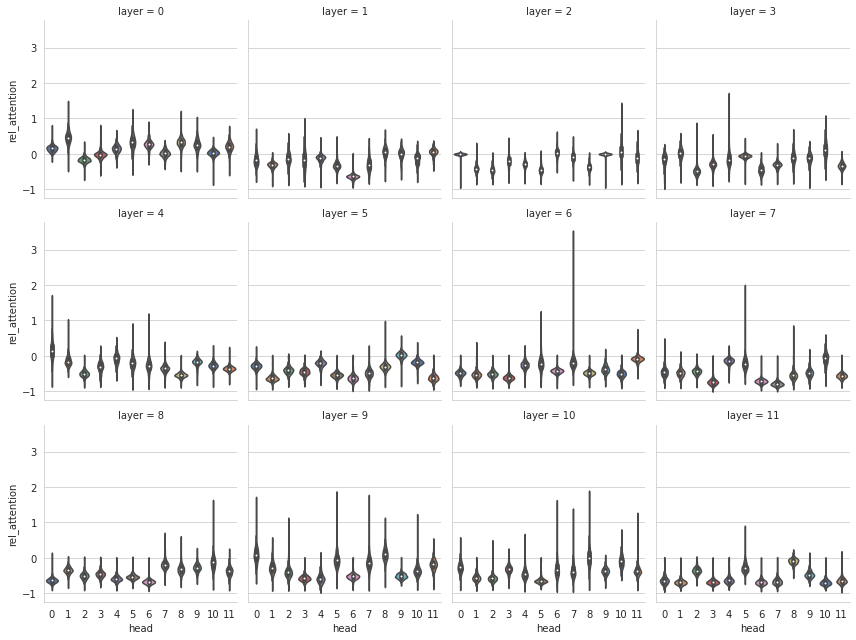

In [16]:
# BERT distributions of attentions for each head
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "bert")]

# plot
sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True, hue="model")
g.map(sns.violinplot, "head", "rel_attention", palette="deep")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

<AxesSubplot:xlabel='layer', ylabel='head'>

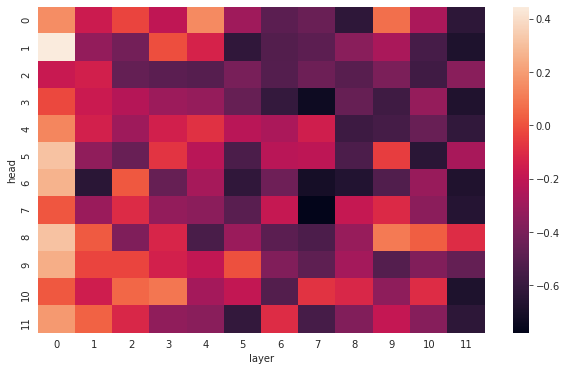

In [17]:
# mean relative attentions (mean_key_attention - mean_NOkey_attention) for each head 
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

In [18]:
# for visualization, we cut-off here the relative attentions bigger than 10: appx 20% of data
len(links_m_df[(links_m_df.rel_attention < 10)]), len(links_m_df[(links_m_df.rel_attention >= 10)])

(208850, 58702)

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


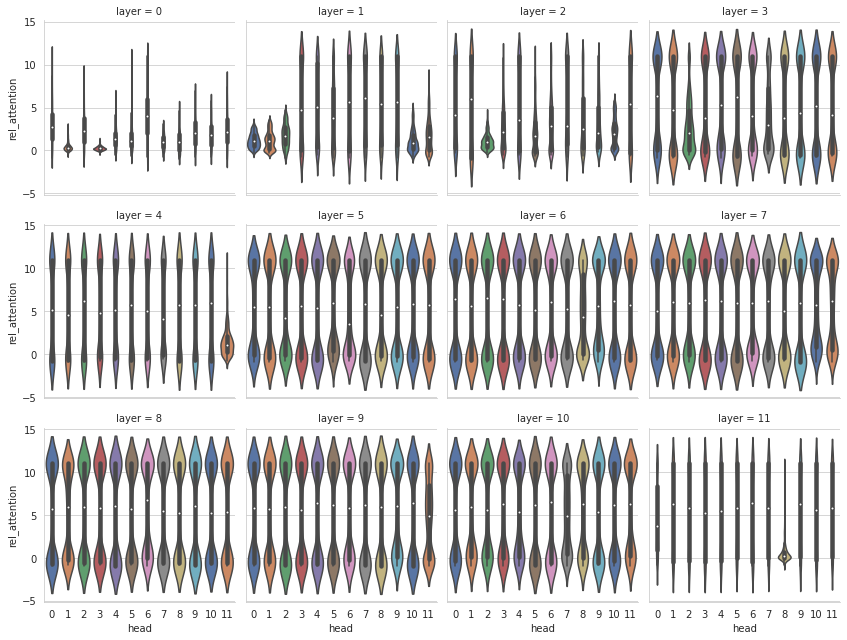

In [19]:
# # mean relative attentions (mean_key_attention - mean_NOkey_attention) for each head: attentions larger than 10 are round down to 11
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]
outliers = links_plot_subset.attention > 10
links_plot_subset.loc[outliers, "rel_attention"] = 11
links_plot_subset = links_plot_subset[links_plot_subset.rel_attention <= 11]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.violinplot, "head", "rel_attention", palette="deep")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


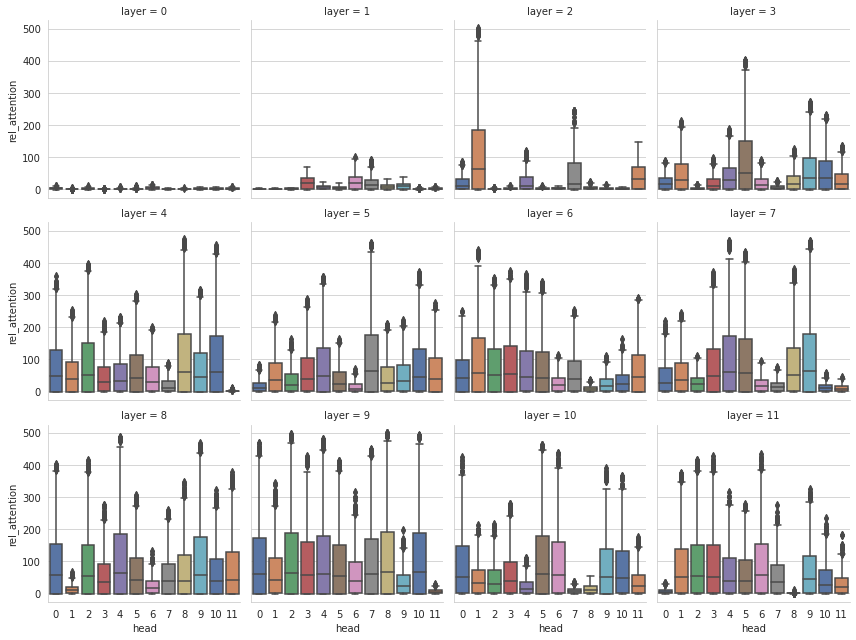

In [20]:
# mean relative attentions: no filtering

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.boxplot, "head", "rel_attention", palette="deep")
# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


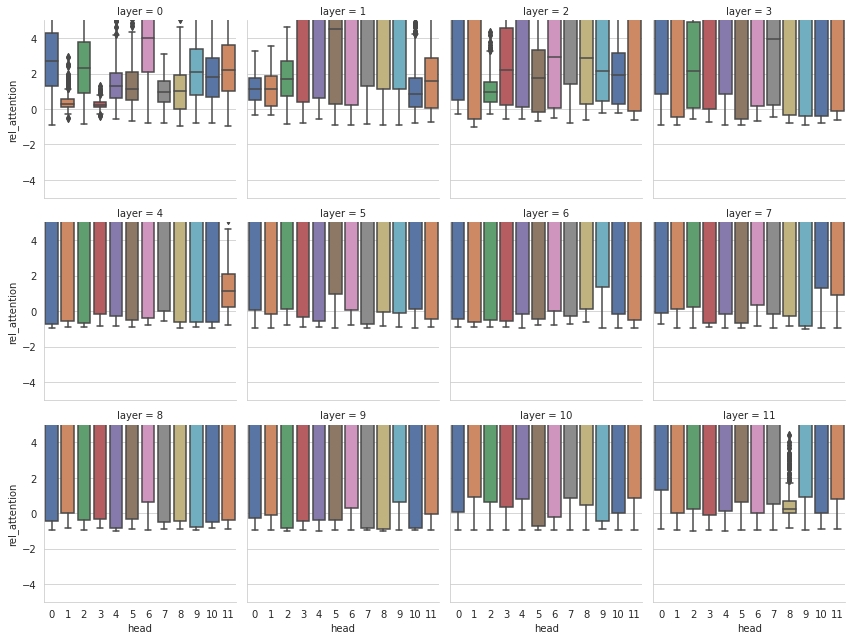

In [21]:
# mean relative attentions: no filtering, Zoom, to zero (=same attentions for key and NOkey parts)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
fgrid = g.map(sns.boxplot, "head", "rel_attention", palette="deep")
plt.ylim(-5, 5)

# g.map(plt.scatter, "head", "rel_attention")
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


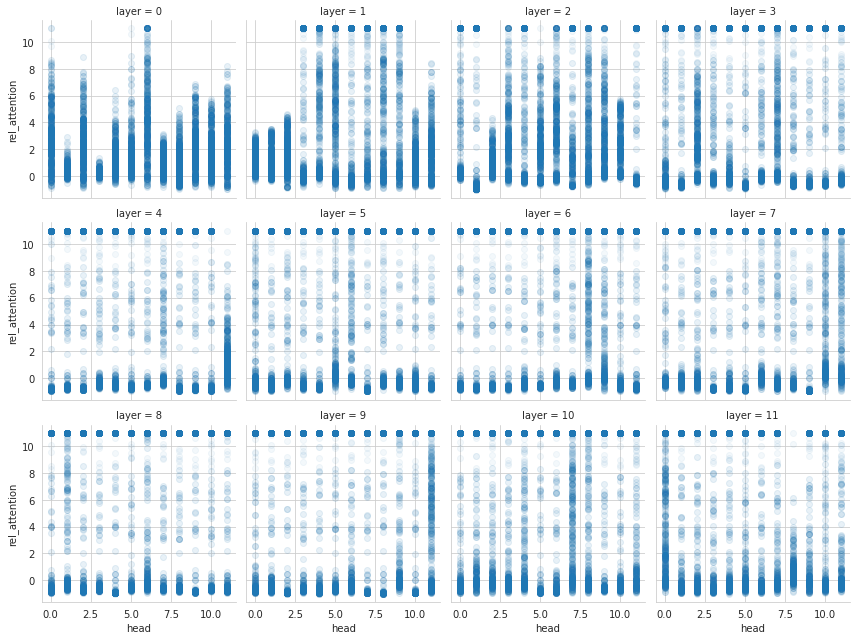

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

links_plot_subset = links_m_df[(links_m_df.model == "gpt")]
outliers = links_plot_subset.attention > 10
links_plot_subset.loc[outliers, "rel_attention"] = 11
links_plot_subset = links_plot_subset[links_plot_subset.rel_attention <= 11]

sns.set_style("whitegrid")

g = sns.FacetGrid(links_plot_subset, col="layer", col_wrap=4, margin_titles=True)
# fgrid = g.map(sns.violinplot, "head", "rel_attention")
g.map(plt.scatter, "head", "rel_attention", alpha=0.05)
# sns.regplot(x=, y=links_m_df[links_m_df.layer == 2].groupby(["head"])["attention"].agg(list), ax=ax)    
sns.despine()

<AxesSubplot:xlabel='layer', ylabel='head'>

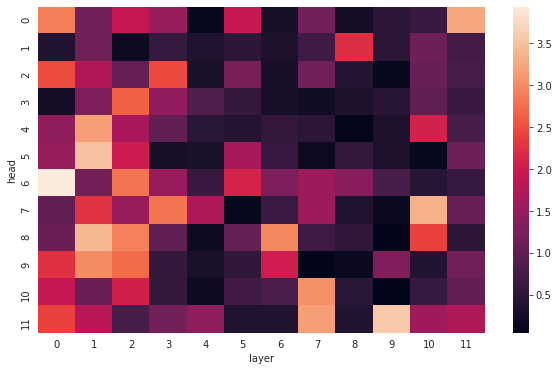

In [23]:
# GPT heatmap, with filtered extremes
links_plot_subset = links_m_df[(links_m_df.rel_attention < 10) & (links_m_df.model == "gpt")]
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

<AxesSubplot:xlabel='layer', ylabel='head'>

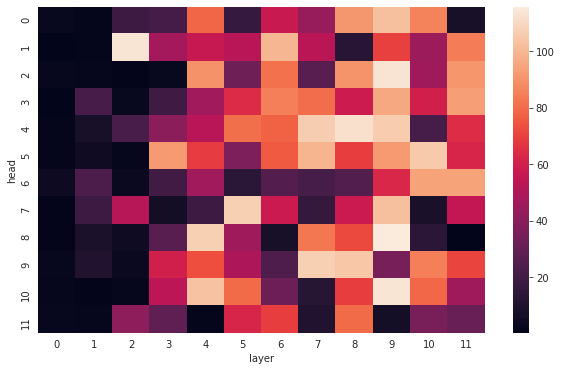

In [24]:
# GPT: we see that extremes filtering here makes a huge difference
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "gpt")]
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab)

<AxesSubplot:xlabel='layer', ylabel='head'>

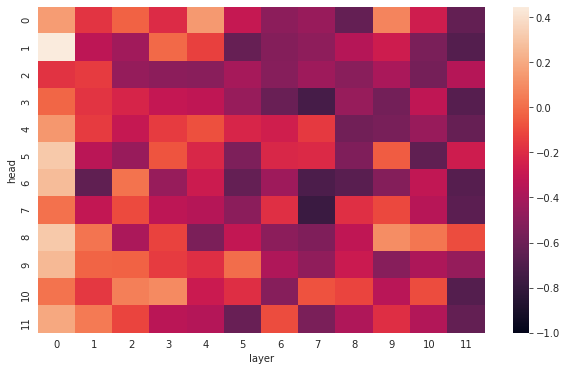

In [33]:
# BERT heatmap
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "bert")]
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab, vmin=-1)

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='layer', ylabel='head'>

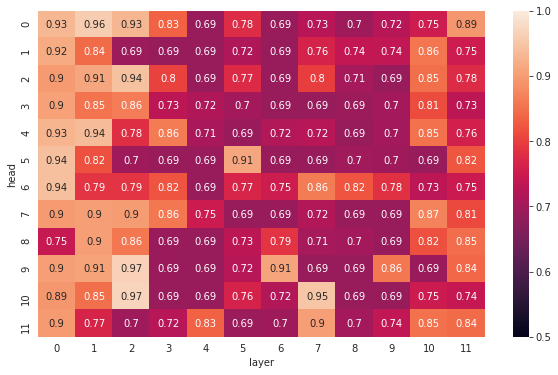

In [40]:
# GPT: for each head, how much % of relative attentions is HIGHER (works better, than lower) than 0
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "gpt")]
links_plot_subset.rel_attention = links_plot_subset.rel_attention.apply(lambda val: 1 if val > 0 else 0)
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab, annot=True, vmin=0.5, vmax=1)

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='layer', ylabel='head'>

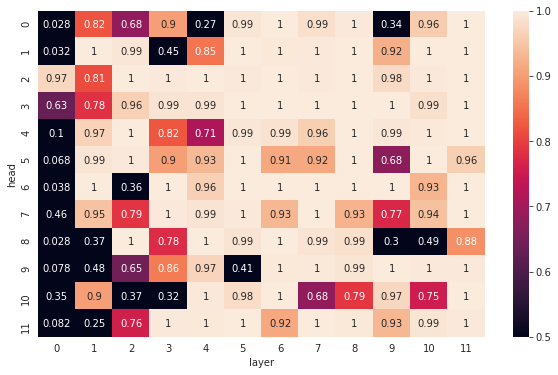

In [37]:
# BERT: how much % of relative attentions is LOWER (works better, than higher) than 0
links_plot_subset = links_m_df[(~links_m_df.rel_attention.isna()) & (links_m_df.model == "bert")]
links_plot_subset.rel_attention = links_plot_subset.rel_attention.apply(lambda val: 1 if val < 0 else 0)
pivot_tab = pd.pivot_table(links_plot_subset, values="rel_attention", index=["head"], columns=["layer"], aggfunc=pd.Series.mean)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_tab, annot=True, vmin=0.5, vmax=1)